In this notebook I will try to assess the correlation between the fitness landscape obtaines trough experimental _deep mutational scans(DMS)_ and the values of the pseudo likelihood for those mutations. This _DMS_ comes from the _deepsequence_ paper, not _Roklin_ or _Frappier_, and its the old dataset prior to the _ProteinGym_ one, which we could also use.  The way to proceed is that given the primary structure of the original sequence(which then gets mutated), we obtain its structure trough **AlphaFold2**, which has shown to have atomic level accuracy in a lot of scenarios. We select the most probable structure given by it, as by default it returns five of them. Once we have the structure we pass it trough the pretrained encoder of the **Evolutionary Scale Modelling** paper to get the encoding, and from there we get the Potts model associated to it. We then evaluate how the pseudo likelihood varies for the set of mutated sequences given by the _DMS_. **We want to compare the correlation of the loss of esm and of our decoder to this fitness landscape**.

In [1]:
from encoded_protein_dataset import EncodedProteinDataset, collate_fn, get_embedding
from pseudolikelihood import get_npll, get_npll2
import torch
import numpy as np
import pandas as pd
import re
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
from Bio import SeqIO


import os, sys
#sys.path.insert(1, "/Data/silva/esm/")
sys.path.insert(1, "D:/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from collections import defaultdict



c:\Users\Luca\anaconda3\envs\IF3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

In [3]:
mutational_dir = 'D:/Data/InverseFolding/Mutational_Data'
protein_original_DMS = 'YAP1_HUMAN_1_b0.5.a2m.wildtype.fasta'
#protein_original_DMS= 'UBE4B_MOUSE_1_b0.45.a2m.wildtype.fasta'
## select one of the models selected in the IntermediateModels folder
model_path = 'D:/Data/InverseFolding/Intermediate_Models/model_20_01_2023_epoch_1000.0.pt'
structure_name = 'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb'
#structure_name = 'UBE4B_MOUSE_1_b0.45.a2m_unrelaxed_rank_5_model_3.pdb'

In [4]:
folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)



In [5]:
#coords

In [6]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [7]:
num_seq[0]

tensor([[ 2, 17, 12,  9, 12,  0,  5, 18,  3, 10,  0,  8, 16, 15, 15,  5, 13, 14,
         19,  4,  9, 11,  6,  7,  2, 13, 16, 16, 16, 18, 13,  2, 12, 14,  8,  0]])

In [8]:
read_fasta

<function ioutils.read_fasta(fasta_path, alphabet='ACDEFGHIKLMNPQRSTVWY-', default_char='-', mutated_exp=False)>

In [9]:
len(native_seq)

36

In [10]:
num_seq[0].shape

torch.Size([1, 36])

In [148]:
coords.shape

(36, 3, 3)

In [8]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

D:\esm\esm\pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [150]:
rep.shape

torch.Size([36, 512])

In [151]:
rep.device

device(type='cpu')

In [111]:
model_full = torch.load(model_path)
model_full;

In [163]:
#Potts_Decoder.keys()

In [112]:
args = model_full['args_run']
input_encoding_dim = rep.shape[1]
q=21
param_embed_dim = args['param_embed_dim']
n_param_heads = args['n_param_heads']
d_model = args['input_encoding_dim']
n_heads = args['n_heads']
n_layers = args['n_layers']
device = 0
eta = model_full['eta']
dropout = args['dropout']


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)

512
512


In [113]:
decoder.load_state_dict(model_full['model_state_dict'])
decoder.eval();

In [114]:
#msa, encodings, padding_mask = collate_fn(rep.unsqueeze(0), q, 1)
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)

In [296]:
rep_padded.shape

torch.Size([1, 36, 512])

In [297]:
padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)
padding_mask.shape

torch.Size([1, 36])

In [298]:
padding_mask.shape

torch.Size([1, 36])

In [299]:
padding_mask = torch.zeros((1,36), dtype=torch.bool)

In [300]:
padding_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False]])

In [301]:
torch.sum(padding_mask)

tensor(0)

In [83]:
couplings, fields = decoder(rep_padded, padding_mask)

## This next line tries saves the model so that we can then generate samples from the Potts model.

In [274]:
B,N,_ = rep_padded.shape
with open("YAP1_HUMAN_couplings_fields.txt", "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)


In [5]:
mutational_file = './alignments/YAP1Fields2012.csv.YAP1_HUMAN_1_b0.5.a2m.exp'
#mutational_file = 'alignments/UBE4B.csv.UBE4B_MOUSE_1_b0.45.a2m.exp'
mutational_path = os.path.join(mutational_dir, mutational_file)
file = pd.read_csv(mutational_path, header=None)

In [6]:
file.head()

,0
0,>YAP1_HUMAN/170-205|L173F|0.581268889|-7.55493...
1,FPAGWEMAKTSSGQRYFLNHIDQTTTWQDP
2,>YAP1_HUMAN/170-205|L173H|0.268812135|-8.68901...
3,HPAGWEMAKTSSGQRYFLNHIDQTTTWQDP
4,>YAP1_HUMAN/170-205|L173M|1.08444462|-4.506080...


In [7]:
def read_exp_old(path):
    vals = {}
    with open(path) as f:
        lines=f.readlines()
        
    for i in range(len(lines)//2):
        occ = [m.start() for m in re.finditer('\|', lines[2*i])]
        val = float(lines[2*i][occ[1]+1:occ[2]])
        ##################### THIS WAS FOR YAP PROTEIN ###########################
        native_seq = 'DVP' + lines[2*i+1][0:-1] + 'RKA'

        ##################### THIS FOR THE MOUSE ###########################################
        #native_seq = str.upper('iaiekfkllaekveeivaknarae') + lines[2*i+1][0:-1] + str.upper('qssdh')
        vals[native_seq] = val
        #B, M = 1,1
        #N = len(native_seq)
    return vals

In [8]:
vals = read_exp_old(mutational_path)

In [32]:
#vals.keys()

In [110]:
from collections import defaultdict

q=21
folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)

padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)


model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
nlls = torch.zeros(len(vals))
iterator=0
#couplings, fields = decoder(rep_padded, padding_mask)
param_embeddings, fields = decoder.forward_new(rep_padded, padding_mask)
for mutated_seq in vals.keys():
    q=21
    B=M=1
    N=len(mutated_seq)
    embedding = get_embedding(q)
    alphabet='ACDEFGHIKLMNPQRSTVWY-'
    default_index = alphabet.index('-')
    aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
    numerical_seq = torch.Tensor([aa_index[c] for c in str(mutated_seq)]).unsqueeze(0).unsqueeze(0)
    numerical_seq = numerical_seq.type(torch.int)
    msas_embedded = embedding(numerical_seq).view(B, M, N, q) #.view(B,M,-1)
    nlls[iterator] = -torch.sum(get_npll2(msas_embedded, param_embeddings, fields, N, q)).item()/N
    iterator+=1
    

D:\esm\esm\pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


NameError: name 'decoder' is not defined

In [92]:
import scipy

In [93]:
fitnesses = [vals[key]for key in vals.keys()]
corr = scipy.stats.spearmanr(fitnesses, np.exp(nlls))
#corr = scipy.stats.pearsonr(fitnesses, nlls)
corr

SignificanceResult(statistic=0.5341329424121797, pvalue=1.740159495581048e-24)

## Let us now test the same coefficent for esm, the pipeline is the same, I just need to change the loss

In [13]:
?Sequence

Signature:       Sequence(*args, **kwargs)
Type:            _SpecialGenericAlias
String form:     typing.Sequence
File:            c:\users\luca\anaconda3\envs\if3\lib\typing.py
Docstring:       A generic version of collections.abc.Sequence.
Class docstring:
The central part of internal API.

This represents a generic version of type 'origin' with type arguments 'params'.
There are two kind of these aliases: user defined and special. The special ones
are wrappers around builtin collections and ABCs in collections.abc. These must
have 'name' always set. If 'inst' is False, then the alias can't be instantiated,
this is used by e.g. typing.List and typing.Dict.

In [3]:
def get_sequence_loss(model, alphabet, coords, seq, device=None):
    batch_converter = CoordBatchConverter(alphabet)    ##This calls the init method of BatchConverter, which is its superclass
    batch = [(coords, None, seq)]
    coords, confidence, strs, tokens, padding_mask = batch_converter(batch, device=device)
    
    #print(padding_mask)
    prev_output_tokens = tokens[:, :-1]
    target = tokens[:, 1:]
    target_padding_mask = (target == alphabet.padding_idx)
    logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)
    loss = F.cross_entropy(logits, target, reduction='none')
    #loss = loss[0].detach().numpy()
    #loss = loss[0].to('cpu').numpy()
    #target_padding_mask = target_padding_mask[0].numpy()
    return loss, target_padding_mask

def get_sequence_loss_decoder(decoder, alphabet, coords, encodings, seq, device=None):
    batch_converter = CoordBatchConverter(alphabet)       ##This calls the init method of BatchConverter, which is its superclass
    if isinstance(seq, list):
        ## In this case I want to batch, coords is going to be batched
        batch = []
        for idx in range(len(seq)):
            ## List is a subscall of sequence, hence should work. Coords is the same for all positions
            batch.append((coords, None, seq[idx]))

    else:
        ## In this case I have a single batch
        batch = [(coords, None, seq)]
    ## Now I use the batch converted, no need to worry where he batches, it is going to be self-consistent    
    coords, confidence, strs, tokens, padding_mask = batch_converter(batch, device=device)
    
    prev_output_tokens = tokens[:, :-1]
    target = tokens[:, 1:]
    target_padding_mask = (target == alphabet.padding_idx)
    #encoder_padding_mask = torch.zeros(1, 38, dtype=bool).to(device)  ## This will be needed if we batch
    encoder_output = {'encoder_out':[encodings], 'encoder_padding_mask':[padding_mask]}
    logits, _ = decoder.forward(prev_output_tokens, encoder_output)#encoder_output)
    loss = F.cross_entropy(logits, target, reduction='none')
    return loss, target_padding_mask

class BatchConverter(object):
    """Callable to convert an unprocessed (labels + strings) batch to a
    processed (labels + tensor) batch.
    """

    def __init__(self, alphabet, truncation_seq_length: int = None):
        self.alphabet = alphabet
        self.truncation_seq_length = truncation_seq_length

    def __call__(self, raw_batch: Sequence[Tuple[str, str]]):
        # RoBERTa uses an eos token, while ESM-1 does not.
        batch_size = len(raw_batch)
        batch_labels, seq_str_list = zip(*raw_batch)   ## Problem here
        seq_encoded_list = [self.alphabet.encode(seq_str) for seq_str in seq_str_list]
        if self.truncation_seq_length:
            seq_encoded_list = [seq_str[:self.truncation_seq_length] for seq_str in seq_encoded_list]
        max_len = max(len(seq_encoded) for seq_encoded in seq_encoded_list)
        tokens = torch.empty(
            (
                batch_size,
                max_len + int(self.alphabet.prepend_bos) + int(self.alphabet.append_eos),
            ),
            dtype=torch.int64,
        )
        tokens.fill_(self.alphabet.padding_idx)
        labels = []
        strs = []

        for i, (label, seq_str, seq_encoded) in enumerate(
            zip(batch_labels, seq_str_list, seq_encoded_list)
        ):
            labels.append(label)
            strs.append(seq_str)
            if self.alphabet.prepend_bos:
                tokens[i, 0] = self.alphabet.cls_idx
            seq = torch.tensor(seq_encoded, dtype=torch.int64)
            tokens[
                i,
                int(self.alphabet.prepend_bos) : len(seq_encoded)
                + int(self.alphabet.prepend_bos),
            ] = seq
            if self.alphabet.append_eos:
                tokens[i, len(seq_encoded) + int(self.alphabet.prepend_bos)] = self.alphabet.eos_idx

        return labels, strs, tokens


class CoordBatchConverter(BatchConverter):
    def __call__(self, raw_batch: Sequence[Tuple[Sequence, str]], device=None):
        """
        Args:
            raw_batch: List of tuples (coords, confidence, seq)
            In each tuple,
                coords: list of floats, shape L x 3 x 3
                confidence: list of floats, shape L; or scalar float; or None
                seq: string of length L
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        self.alphabet.cls_idx = self.alphabet.get_idx("<cath>") 
        batch = []
        for coords, confidence, seq in raw_batch:
            if confidence is None:
                confidence = 1.
            if isinstance(confidence, float) or isinstance(confidence, int):
                confidence = [float(confidence)] * len(coords)
            if seq is None:
                seq = 'X' * len(coords)
            batch.append(((coords, confidence), seq))

        coords_and_confidence, strs, tokens = super().__call__(batch)

        # pad beginning and end of each protein due to legacy reasons
        coords = [
            F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)
            for cd, _ in coords_and_confidence
        ]
        confidence = [
            F.pad(torch.tensor(cf), (1, 1), value=-1.)
            for _, cf in coords_and_confidence
        ]
        coords = self.collate_dense_tensors(coords, pad_v=np.nan)
        confidence = self.collate_dense_tensors(confidence, pad_v=-1.)
        if device is not None:
            coords = coords.to(device)
            confidence = confidence.to(device)
            tokens = tokens.to(device)
        padding_mask = torch.isnan(coords[:,:,0,0])
        coord_mask = torch.isfinite(coords.sum(-2).sum(-1))
        confidence = confidence * coord_mask + (-1.) * padding_mask
        return coords, confidence, strs, tokens, padding_mask

    def from_lists(self, coords_list, confidence_list=None, seq_list=None, device=None):
        """
        Args:
            coords_list: list of length batch_size, each item is a list of
            floats in shape L x 3 x 3 to describe a backbone
            confidence_list: one of
                - None, default to highest confidence
                - list of length batch_size, each item is a scalar
                - list of length batch_size, each item is a list of floats of
                    length L to describe the confidence scores for the backbone
                    with values between 0. and 1.
            seq_list: either None or a list of strings
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        batch_size = len(coords_list)
        if confidence_list is None:
            confidence_list = [None] * batch_size
        if seq_list is None:
            seq_list = [None] * batch_size
        raw_batch = zip(coords_list, confidence_list, seq_list)
        return self.__call__(raw_batch, device)

    @staticmethod
    def collate_dense_tensors(samples, pad_v):
        """
        Takes a list of tensors with the following dimensions:
            [(d_11,       ...,           d_1K),
             (d_21,       ...,           d_2K),
             ...,
             (d_N1,       ...,           d_NK)]
        and stack + pads them into a single tensor of:
        (N, max_i=1,N { d_i1 }, ..., max_i=1,N {diK})
        """
        if len(samples) == 0:
            return torch.Tensor()
        if len(set(x.dim() for x in samples)) != 1:
            raise RuntimeError(
                f"Samples has varying dimensions: {[x.dim() for x in samples]}"
            )
        (device,) = tuple(set(x.device for x in samples))  # assumes all on same device
        max_shape = [max(lst) for lst in zip(*[x.shape for x in samples])]
        result = torch.empty(
            len(samples), *max_shape, dtype=samples[0].dtype, device=device
        )
        result.fill_(pad_v)
        for i in range(len(samples)):
            result_i = result[i]
            t = samples[i]
            result_i[tuple(slice(0, k) for k in t.shape)] = t
        return result
    

In [10]:
?Sequence

Signature:       Sequence(*args, **kwargs)
Type:            _SpecialGenericAlias
String form:     typing.Sequence
File:            c:\users\luca\anaconda3\envs\if3\lib\typing.py
Docstring:       A generic version of collections.abc.Sequence.
Class docstring:
The central part of internal API.

This represents a generic version of type 'origin' with type arguments 'params'.
There are two kind of these aliases: user defined and special. The special ones
are wrappers around builtin collections and ABCs in collections.abc. These must
have 'name' always set. If 'inst' is False, then the alias can't be instantiated,
this is used by e.g. typing.List and typing.Dict.

In [4]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

In [12]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();
#model.to(device);

D:\esm\esm\pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [13]:
coords, native_seq = extract_coords_from_structure(structure)
encoder_esm = model.encoder

## Forward of encoder 
batch_converter = CoordBatchConverter(alphabet)

# the batch_converter is essential for forming the correct input format
batch = [(coords, None, None)] * 1
coords_aux, confidence, _, _, padding_mask = batch_converter(batch)
with torch.no_grad():
        encoder_out = model.encoder.forward(coords_aux, padding_mask, confidence,
                return_all_hiddens=False)['encoder_out'][0]
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
#rep = encoder_esm(alphabet, coords)
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=False, padding_value=0.0)
decoder_esm = model.decoder
decoder_esm.eval();


In [14]:
rep[0, 0:5]

tensor([0.1843, 0.2766, 0.1400, 0.0408, 0.6755], grad_fn=<SliceBackward0>)

In [15]:
encoder_out[1:-1].shape

torch.Size([36, 1, 512])

In [16]:
encoder_out.shape

torch.Size([38, 1, 512])

In [17]:
encoder_out.shape

torch.Size([38, 1, 512])

In [32]:
#?decoder_esm.forward

In [24]:
#B=4
import time
#encoder_out_batched = (torch.tensor(encoder_out.clone().detach())).unsqueeze(1).repeat(1, B, 1, 1)

#device='cpu'
device=0
loss_esm_log = torch.zeros(len(vals)).to(device)
loss_esm_log2 = torch.zeros(len(vals)).to(device)

##Send things to device
decoder_esm.to(device)
encoder_out = encoder_out.to(device)

iterator=0
start = time.time()
batch_size = 9
mutated_sequences = list(vals.keys())
encoder_out_batched = encoder_out.unsqueeze(1).repeat(1, batch_size, 1, 1)
#for mutated_seq in vals.keys():
with torch.no_grad():
    for batch_idx in range(len(mutated_sequences)//batch_size):
        mutated_seq_batched = mutated_sequences[batch_idx*batch_size:(batch_idx+1)*batch_size]
        #res2 = get_sequence_loss(model, alphabet, coords, mutated_seq, device=device)[0]
        #mutated_seq_batched = [mutated_seq]*B
        res = get_sequence_loss_decoder(decoder_esm, alphabet, coords, encoder_out_batched, mutated_seq_batched, device=device)[0]
        loss_esm_log[iterator*batch_size:(iterator+1)*batch_size] = -torch.sum(res, axis=1)#.item()
        #loss_esm_log2[iterator]= -torch.sum(res2).item()
        iterator+=1
        if iterator > 10:
            break
    print(f"It took {time.time()-start} seconds to do 1000 iterations")

It took 0.31749987602233887 seconds to do 1000 iterations


In [27]:
len(vals.keys())

313

In [33]:
len(loss_esm_log)

313

It took 2.5 seconds for 800 non batched vs 0.14 batched

In [90]:
for i in range(6//2+1):
    print(i*2, (i+1)*2)

0 2
2 4
4 6
6 8


In [92]:
l= [1,2,3]
l[4:6]

[]

In [33]:
res.shape

torch.Size([4, 36])

In [191]:
isinstance([mutated_seq], list)

True

In [176]:
[mutated_seq]*2

['DVPMPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA',
 'DVPMPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA']

In [159]:
res

tensor([[2.8144e+00, 2.3564e+00, 7.9371e-01, 2.3397e+00, 7.9662e-04, 2.4601e+00,
         2.8497e-03, 6.0357e-01, 1.2587e+00, 3.5361e+00, 3.5906e+00, 2.0207e+00,
         6.4651e-01, 2.0613e+00, 1.5919e+00, 3.8902e-04, 2.2504e+00, 3.9504e+00,
         1.8226e+00, 1.5408e+00, 3.8291e+00, 6.1535e-01, 1.5325e+00, 3.2863e+00,
         4.0418e+00, 2.7766e+00, 4.2226e-01, 3.0355e+00, 1.1044e+00, 1.9604e-01,
         2.8210e+00, 4.9642e-02, 1.5300e-05, 8.0432e-03, 2.5582e+00, 3.1314e+00]],
       grad_fn=<ViewBackward0>)

In [160]:
res2

tensor([[2.8144e+00, 2.3564e+00, 7.9371e-01, 2.3397e+00, 7.9662e-04, 2.4601e+00,
         2.8497e-03, 6.0357e-01, 1.2587e+00, 3.5361e+00, 3.5906e+00, 2.0207e+00,
         6.4651e-01, 2.0613e+00, 1.5919e+00, 3.8902e-04, 2.2504e+00, 3.9504e+00,
         1.8226e+00, 1.5408e+00, 3.8291e+00, 6.1535e-01, 1.5325e+00, 3.2863e+00,
         4.0418e+00, 2.7766e+00, 4.2226e-01, 3.0355e+00, 1.1044e+00, 1.9604e-01,
         2.8210e+00, 4.9642e-02, 1.5300e-05, 8.0432e-03, 2.5582e+00, 3.1314e+00]],
       grad_fn=<ViewBackward0>)

In [161]:
loss_esm_log[0:5]

tensor([-69.3813, -72.6738, -65.0502,   0.0000,   0.0000])

In [162]:
loss_esm_log2[0:5]

tensor([-69.3813, -72.6738, -65.0502,   0.0000,   0.0000])

In [ ]:
loss_esm_log = torch.zeros(len(vals))
iterator=0
for mutated_seq in vals.keys():
    #res=get_sequence_loss(model, alphabet, coords, mutated_seq, device=device)[0]
    loss_esm_log[iterator]= -torch.sum(res).item()
    iterator+=1

In [99]:
corr = scipy.stats.spearmanr(fitnesses, loss_esm_log)
#corr = scipy.stats.pearsonr(fitnesses, np.exp(loss_esm_log))
corr


SignificanceResult(statistic=0.5850077406771409, pvalue=3.940233587429067e-30)

In [119]:
import matplotlib.pyplot as plt

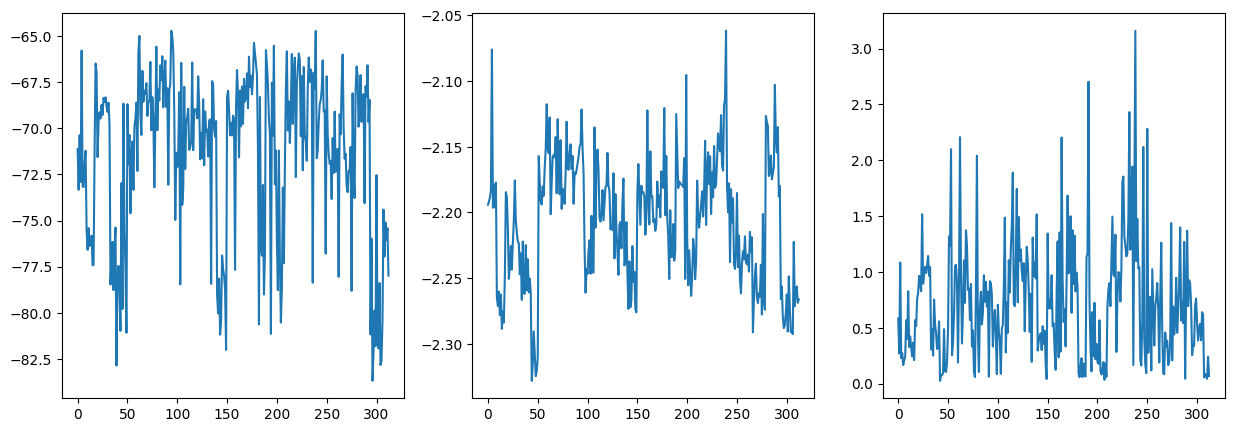

In [125]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
ax1.plot(loss_esm_log)
ax2.plot(nlls)
ax3.plot(fitnesses)

## Now we want to loop across all of them to get better comparison

In [28]:
def read_exp_old(path):
    vals = {}
    with open(path) as f:
        lines=f.readlines()
    
    for i in range(len(lines)//2):
        occ = [m.start() for m in re.finditer('\|', lines[2*i])]
        val = float(lines[2*i][occ[1]+1:occ[2]])
        ##################### THIS WAS FOR YAP PROTEIN ###########################
        native_seq = 'DVP' + lines[2*i+1][0:-1] + 'RKA'

        ##################### THIS FOR THE MOUSE ###########################################
        #native_seq = str.upper('iaiekfkllaekveeivaknarae') + lines[2*i+1][0:-1] + str.upper('qssdh')
        vals[native_seq] = val
        #B, M = 1,1
        #N = len(native_seq)
    return vals

In [5]:
def extract_lower(str):
    beg = ""
    end = ""
    for char in str:
        if char.islower():
            beg = beg+char
        else:
            break
    for i in range(len(str)):
        if str[-i-1].islower():
            end = end+(str[-i-1])
        else:
            break
    return beg, end[::-1]

def read_exp_old(path, str_full):
    vals = {}
    beg, end = extract_lower(str_full)
    with open(path) as f:
        lines=f.readlines()
    
    for i in range(len(lines)//2):
        occ = [m.start() for m in re.finditer('\|', lines[2*i])]
        val = float(lines[2*i][occ[1]+1:occ[2]])
        ##################### THIS WAS FOR YAP PROTEIN ###########################
        native_seq = beg.upper() + lines[2*i+1][0:-1] + end.upper()

        ##################### THIS FOR THE MOUSE ###########################################
        #native_seq = str.upper('iaiekfkllaekveeivaknarae') + lines[2*i+1][0:-1] + str.upper('qssdh')
        vals[native_seq] = val
        #B, M = 1,1
        #N = len(native_seq)
    return vals

def case_change_indices(s):
    indices = []
    for i in range(1, len(s)):
        if s[i].isupper() != s[i-1].isupper():
            indices.append(i)
    return indices


def read_exp(path, str_full):
    vals = {}
    indices = case_change_indices(str_full)
    with open(path) as f:
        lines=f.readlines()
    
    for i in range(len(lines)//2):
        occ = [m.start() for m in re.finditer('\|', lines[2*i])]
        val = float(lines[2*i][occ[1]+1:occ[2]])
        native_seq = ""
        old_mark_exp=0
        if str_full[0].islower():
            for changes in range(len(indices)):
                if changes%2==0:
                    ## Here are the lower indices we have to insert
                    if changes == 0:
                        native_seq += str_full[0:indices[changes]].upper()
                    else: 
                        native_seq += str_full[indices[changes-1]:indices[changes]].upper()
                else:
                    ## Here In the indices I am looking at an index where we pass from upper case to lower case
                    ## We hence have to insert the Sequence of the experiment.
                    native_seq += lines[2*i+1][old_mark_exp:old_mark_exp+(indices[changes]-indices[changes-1])]
                    ## I have to keep track of the index in the string of the experiment 
                    old_mark_exp += indices[changes]-indices[changes-1]
            if len(indices)%2==0:
                ## I need to add the last lower case characters
                native_seq += str_full[indices[-1]:].upper()
            else:
                ## We need to add the last characters of the uppercase
                native_seq += lines[2*i+1][old_mark_exp:-1]
        else:
            for changes in range(len(indices)):
                if changes%2==1:
                    ## Here are the lower indices we have to insert
                    native_seq += str_full[indices[changes-1]:indices[changes]].upper()
                else:
                    if changes == 0:
                        native_seq += lines[2*i+1][old_mark_exp:old_mark_exp+(indices[0])]
                        old_mark_exp += indices[0]
                    else: 
                    ## Here In the indices I am looking at an index where we pass from upper case to lower case
                    ## We hence have to insert the Sequence of the experiment.
                        native_seq += lines[2*i+1][old_mark_exp:old_mark_exp+(indices[changes]-indices[changes-1])]
                    ## I have to keep track of the index in the string of the experiment 
                        old_mark_exp += indices[changes]-indices[changes-1]
            if len(indices)%2==1:
                ## I need to add the last lower case characters
                native_seq += str_full[indices[-1]:].upper()
            else:
                ## We need to add the last characters of the uppercase
                native_seq += lines[2*i+1][old_mark_exp:-1]            
            ## Here if I start with a lower case
        vals[native_seq] = val
        #B, M = 1,1
        #N = len(native_seq)
    return vals

In [45]:
DMS_exp = read_exp(os.path.join(alignments_folder, exp_file), str_full)

NameError: name 'alignments_folder' is not defined

In [276]:
for el in DMS_exp.keys():
    if len(el)!=len(str_full):
        print("PROBLEM")

## Load esm model and Potts decoder

In [6]:
#device='cpu'
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();
model.to('cpu');

model_path = 'D:/Data/InverseFolding/Intermediate_Models/model_20_01_2023_epoch_1000.0.pt'
model_full = torch.load(model_path)

args = model_full['args_run']
input_encoding_dim = 512 #rep.shape[1], CONTROL IF 512 IS CORRECT
q=21
param_embed_dim = args['param_embed_dim']
n_param_heads = args['n_param_heads']
d_model = args['input_encoding_dim']
n_heads = args['n_heads']
n_layers = args['n_layers']
eta = model_full['eta']
dropout = args['dropout']


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.load_state_dict(model_full['model_state_dict'])
decoder.eval();
decoder.to('cpu');

## Send the esm decoder to GPU
decoder_esm = model.decoder.to(0)


D:\esm\esm\pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


512
512


## Now let us load the already calculated quantites

In [36]:
import pickle

with open('partial_results_fitness_prediction.pkl', mode="rb") as f:
    res_prev = pickle.load(f)

In [7]:
import scipy
prots_prev = []

In [8]:
alignments_folder = "D:/Data/InverseFolding/Mutational_Data/alignments"
af_folder = "D:/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/"

## I comment these lines deu to the fact that there was a mistake and I didn't want to throws away all the computations
corrs_potts = []
corrs_esm = []
prots = []
it_prots = len(prots_prev)
for prot in os.listdir(alignments_folder):
    if prot in prots_prev:
        print("I have already computed the calculations for this protein, skip")
        continue ##I go to the next iteration of the for loop
    it_prots+=1
    print(f"We are at protein number {it_prots} out of {len(os.listdir(alignments_folder))}")
    if prot.endswith('fasta'):
        id = prot[0:4]
        check_exp = 0
        for exp_files in os.listdir(alignments_folder):
            if 'ABLE' in prot:
                if ('ABLE' in exp_files and exp_files.endswith('exp')):
                    if exp_files[0:4] == id:
                        #print(f"1 prot: {prot}, ID:{id}, exp_file:{exp_files}")
                        exp_file = exp_files
                        check_exp+=1
                        break
            elif ('hmmerbit' in prot):
                if 'hmmerbit' in exp_files and exp_files.endswith('exp'):
                    if exp_files[0:4] == id:
                        #print(f"2 prot: {prot}, ID:{id}, exp_file:{exp_files}")
                        exp_file = exp_files
                        check_exp+=1
                        break
            elif ('BRCT' in prot):
                if 'BRCT' in exp_files and exp_files.endswith('exp'):
                    if exp_files[0:4] == id:
                        #print(f"3 prot: {prot},ID:{id}, exp_file:{exp_files}")
                        exp_file = exp_files
                        check_exp+=1
                        break
            else:
                crit = ['ABLE', 'hmmerbit', 'BRCT']
                x = [c in exp_files for c in crit]
                if (sum(x)== 0 and exp_files.endswith('exp')):
                    if exp_files[0:4] == id:
                        #print(f"x: {x}, 4 prot: {prot},ID:{id}, exp_file:{exp_files}")
                        exp_file = exp_files
                        check_exp+=1
                        break
        #print("\n\n")
        if check_exp==0:
            #print(f"We did not find the experiment for protein:{prot}\n")
            continue #break ##we exit this iteration
        
        #print("I shoul not see this if we don't find a protein")
        seq_records = list(SeqIO.parse(os.path.join(alignments_folder, prot), 'fasta'))
        str_full = str(seq_records[0].seq)        
        wildtype = read_fasta(os.path.join(alignments_folder, prot), mutated_exp=True)
        #padding_mask = (wildtype[0].unsqueeze(1)[:, 0, :] == q)

        DMS_exp = read_exp(os.path.join(alignments_folder, exp_file), str_full)
        
        check=0
        for af_pdb in os.listdir(af_folder):
            if 'ABLE' in prot:
                if ('ABLE' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"1 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            elif 'hmmerbit' in prot:
                if ('hmmerbit' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"2 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            elif 'BRCT' in prot:
                if ('BRCT' in af_pdb and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"3 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)
                            break
            else:
                crit = ['ABLE', 'hmmerbit', 'BRCT']
                x = [c in af_pdb for c in crit]
                if (sum(x)==0 and af_pdb.endswith('pdb')):
                    if id == af_pdb[0:4]:
                        if 'rank_1' in af_pdb:
                            print(f"4 prot: {prot}, ID:{id}, afpdb:{af_pdb}, exp_file:{exp_file}")
                            check+=1
                            structure =  load_structure(os.path.join(af_folder, af_pdb))
                            coords, native_seq = extract_coords_from_structure(structure)     
                            break

        if check==0:
            print("I have not found an AF pdb")         
            continue

        #coords = torch.tensor(coords).to(device)
        print("I getting the representation from esm")
        batch_converter = CoordBatchConverter(alphabet)
        batch = [(coords, None, None)] * 1
        coords_aux, confidence, _, _, padding_mask = batch_converter(batch)
        with torch.no_grad():
            ## This version has also BOS and EOS, we need it for esm loss
            encoder_out = model.encoder.forward(coords_aux, padding_mask, confidence,
                return_all_hiddens=False)['encoder_out'][0]
        #with torch.no_grad():
            #rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
            #rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
            #rep_padded = encoder_out[1:-1]
            nlls = torch.zeros(len(DMS_exp))
            iterator=0
            print("Getting param_embedding and fields for Potts decoder")
            param_embeddings, fields = decoder.forward_new(torch.transpose(encoder_out[1:-1],0,1), padding_mask[:, 1:-1])  

        ## Now we have to get the encoder_output for the esm part


        print("Calculating the losses for the Potts decoder, this is reasonably fast")
        for mutated_seq in DMS_exp.keys():
            q=21
            B=M=1
            N=len(mutated_seq)
            embedding = get_embedding(q)
            alphabet_inner='ACDEFGHIKLMNPQRSTVWY-'
            default_index = alphabet_inner.index('-')
            aa_index = defaultdict(lambda: default_index, {alphabet_inner[i]: i for i in range(len(alphabet_inner))})
            numerical_seq = torch.Tensor([aa_index[c] for c in str(mutated_seq)]).unsqueeze(0).unsqueeze(0)
            numerical_seq = numerical_seq.type(torch.int)
            msas_embedded = embedding(numerical_seq).view(B, M, N, q) #.view(B,M,-1)
            nlls[iterator] = -torch.sum(get_npll2(msas_embedded, param_embeddings, fields, N, q)).item()/N
            iterator+=1
        print("Calculating the losses for esm, it is very very slow")
        ## We have to batch the calculations

    
        #device = 0
        #model.to(device)
        ## Send to GPU
        loss_esm_log = torch.zeros(len(DMS_exp)).to(0)
        #iterator=0
        batch_size = 96 
        ## Send encoder output to GPU
        encoder_out = encoder_out.to(0)
        encoder_out_batched = encoder_out.unsqueeze(1).repeat(1, batch_size, 1, 1)
        #encoder_out_batched = encoder_out.unsqueeze(1)
        mutated_sequences = list(DMS_exp.keys())
        with torch.no_grad():
            with torch.cuda.amp.autocast(): ### We reduce the fixed point precision to increase speed
        #        for mutated_seq in DMS_exp.keys():
                for batch_idx in range(len(mutated_sequences)//batch_size):
                    mutated_seq_batched = mutated_sequences[batch_idx*batch_size:(batch_idx+1)*batch_size]
                    if len(mutated_seq_batched)==0:
                        continue
                    #if len(mutated_seq)-1
                    res = get_sequence_loss_decoder(decoder_esm, alphabet, coords, encoder_out_batched, mutated_seq_batched, device=0)[0]
                    #res=get_sequence_loss(model, alphabet, coords, mutated_seq, device=device)[0]
                    loss_esm_log[batch_idx*batch_size:(batch_idx +1)*batch_size]= -torch.sum(res, axis=1)#.item()
                    #iterator+=1

                ## We know just miss possibly the last minibatch
                mutated_seq_batched = mutated_sequences[batch_size*(batch_idx+1):]
                batch_last = len(mutated_seq_batched)
                if batch_last>0:
                    encoder_out_batched = encoder_out_batched[:, 0:batch_last,:,:]
                    res = get_sequence_loss_decoder(decoder_esm, alphabet, coords, encoder_out_batched, mutated_seq_batched, device=0)[0]
                    loss_esm_log[(batch_idx+1)*batch_size:]= -torch.sum(res, axis=1)#.item()


        ## Move back to CPU
        loss_esm_log = loss_esm_log.to('cpu')
        fitnesses = [DMS_exp[key]for key in DMS_exp.keys()]
        corr_potts = scipy.stats.spearmanr(fitnesses, nlls)[0]
        corr_esm = scipy.stats.spearmanr(fitnesses, loss_esm_log)[0]
        print(f"corr potts is:{corr_potts}, corr_esm is:{corr_esm}")

        prots.append(prot)
        corrs_esm.append(corr_esm)
        corrs_potts.append(corr_potts)
        print("\n")
        
        
    

We are at protein number 1 out of 82
We are at protein number 2 out of 82
4 prot: AMIE_PSEAE_1_b0.3.a2m.wildtype.fasta, ID:AMIE, afpdb:AMIE_PSEAE_1_b0.3.a2m_unrelaxed_rank_1_model_5.pdb, exp_file:AMIE_PSEAE.csv.AMIE_PSEAE_1_b0.3.a2m.exp
I getting the representation from esm
Getting param_embedding and fields for Potts decoder
Calculating the losses for the Potts decoder, this is reasonably fast
Calculating the losses for esm, it is very very slow
corr potts is:0.4410630646982261, corr_esm is:0.48081685579357425


We are at protein number 3 out of 82
We are at protein number 4 out of 82
We are at protein number 5 out of 82
1 prot: B3VI55_LIPSTSTABLE_1_b0.5.a2m.wildtype.fasta, ID:B3VI, afpdb:B3VI55_LIPSTSTABLE_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb, exp_file:B3VI55_LIPSTSTABLE.csv.B3VI55_LIPSTSTABLE_1_b0.5.a2m.exp
I getting the representation from esm
Getting param_embedding and fields for Potts decoder
Calculating the losses for the Potts decoder, this is reasonably fast
Calculating th

In [9]:
import pickle

In [10]:
full_results = {}
full_results['prots'] = prots
full_results['corr_esm'] = corrs_esm
full_results['corr_potts'] = corrs_potts



In [13]:
with open("results_fitness_prediction.pkl", mode="wb") as f:
    pickle.dump(full_results, f)

In [16]:
esm_res = [corr for corr in corrs_esm]

In [17]:
potts_res = [corr for corr in corrs_potts]

In [18]:
import matplotlib.pyplot as plt

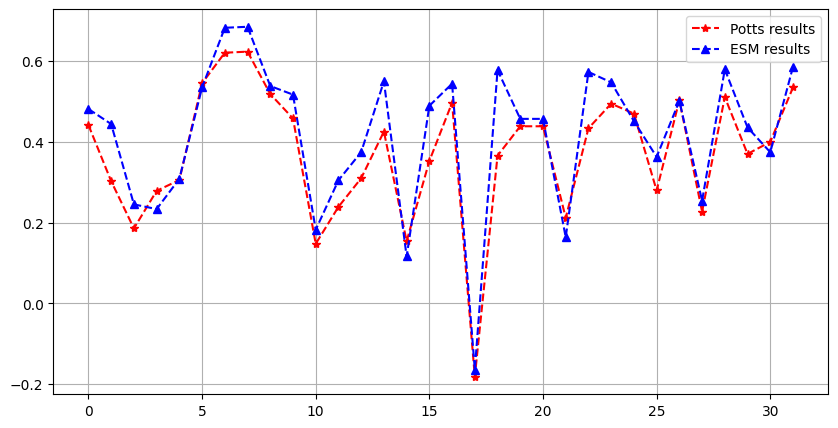

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.plot(potts_res, linestyle="--", marker="*", color='red', label="Potts results")
ax.plot(esm_res, linestyle="--", marker="^", color="blue",label="ESM results")
plt.grid()
plt.legend()

In [20]:
#fig.savefig("results_fitness_prediction.png", format='png')

In [283]:
next(model.parameters()).is_cuda

True

In [287]:
coords.is_cuda

AttributeError: 'numpy.ndarray' object has no attribute 'is_cuda'

Understood the problem, the lower caps letters are not necessarly only at the beginning and end, we have to create a more advanced algorithm to deal with this. 

In [226]:
path =os.path.join(alignments_folder, exp_file)
vals = {}
beg, end = extract_lower(str_full)
with open(path) as f:
    lines=f.readlines()
    
for i in range(len(lines)//2):
    occ = [m.start() for m in re.finditer('\|', lines[2*i])]
    val = float(lines[2*i][occ[1]+1:occ[2]])
    ##################### THIS WAS FOR YAP PROTEIN ###########################
    native_seq = beg.upper() + lines[2*i+1][0:-1] + end.upper()

        ##################### THIS FOR THE MOUSE ###########################################
        #native_seq = str.upper('iaiekfkllaekveeivaknarae') + lines[2*i+1][0:-1] + str.upper('qssdh')
    vals[native_seq] = val

In [228]:

i=1
len(lines[2*i+1][0:-1])

247

In [230]:
str_full

'mrhgdisssndtVGVAVVNYKMprlhtAAEVLDNARKIAEMIVGMKQGlpGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTgerheEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGpKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSqnhlfkilhrgysglqasgdgdrglaecpfefyrtwvtdaekarenverltrsttgvaqcpvgrlpyeglekea'

In [218]:
DMS_exp = read_exp(os.path.join(alignments_folder, exp_file), str_full)

In [223]:
for key in DMS_exp.keys():
    print(len(key))

333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333


In [198]:
exp_file

'AMIE_PSEAE.csv.AMIE_PSEAE_1_b0.3.a2m.exp'

In [199]:
af_pdb

'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_5_model_1_scores.json'

In [108]:
f2 = 'mpiatstgdnvldFTVLGLNSGTSMDGIDCALCHFYQKTPdapmeFELLEYGEVPLAQPIKQRVMRMILEDTTSPSELSEVNVILGEHFADAVRQFAAERNVDLSTIDAIASHGQTIWLLSMpeegqVKSALTMAEGAIIAARTGITSITDFRISDQAAGRQGAPLIAFFDALLLHHPTKLRACQNIGGIANVCFIPPDvdgrrtDEYYDFDTGPGNVFIDAVVRHFTNgeQEYDKDGAMGKRGKVDQELVDDFLKMPYFQLDPPKTTGREVFRDTLAHDLIRRAeaKGLSPDDIVATTTRITAQAIVDHYRRYAPSqEIDEIFMCGGGAYNPNIVEFIQQSYPNTKIMMLDEAGVPAGAKEAITFAWQGMECLVGRSIPVPTRVETRQHYVLGKVSPglnyrsvmkkgmafggdaqqlpwvsemivkkkgkvitnnwa'

In [110]:
len(f1) == len(f2)

True

In [61]:
beg, end = extract_lower(str_full)

In [62]:
beg

'dvp'

In [64]:
end

'rka'